# **Analysis of the 2020 US Elections Hashtag Network**

**Authors:**
- Radu-Andrei Bourceanu
- Juan Arturo Abaurrea Calafell

##  Introduction

Social Network Analysis (SNA) allows us to model complex systems by analyzing the interactions between their components. This project applies SNA techniques to analyze the digital conversation surrounding the 2020 United States Presidential Elections.

### A. Dataset Description
The analysis is based on the network file **`hashtags_cleaned.graphml`**. The dataset was collected using a snowball sampling technique starting from the hashtag **#elections2020**, capturing tweets in multiple languages.

In this graph representation:
* **Nodes:** Represent hashtags used in the dataset.
* **Edges:** Connect two nodes if the hashtags appeared together in the same tweet.
* **Weights:** The edge attribute "weight" represents the number of tweets in which the two hashtags appeared together.

### B. Objectives and Methodology
The goal of this project is to characterize the structure of the network and extract semantic insights regarding the political discussion. Following the course methodology, the analysis is divided into three main levels:

1.  **Meso-Analysis (Community Detection):**
    * We will identify communities (groups of densely connected hashtags) to understand the different topics of discussion.
    * We will use the **Leiden Algorithm**, a method designed to improve upon Louvain by guaranteeing well-connected communities.
    * We will then treat these communities as independent graphs and calculate their structural similarity using **Weisfeiler-Lehman Graph Kernels**, which generate feature vectors for graph comparison (similar to a "bag-of-words" for graphs).

2.  **Macro-Analysis (Global Structure):**
    * To handle the complexity of the large graph, we will perform **graph contraction**, collapsing each community into a single super-node to analyze the global topology more efficiently.
    * We will evaluate whether an overlapping community structure would be more appropriate than a non-overlapping partition.

3.  **Micro-Analysis (Centrality & Prediction):**
    * We will calculate centrality metrics (such as **Degree** and **Betweenness**) to identify "Hubs" (central topics) and "Bridges" (connectors between topics).
    * Finally, we will apply **Link Prediction** algorithms (e.g., Jaccard, Adamic-Adar) to determine which communities have the highest probability of becoming connected in the future.

## Imports

In [2]:
# Data Handling & Math
import networkx as nx
import pandas as pd
import numpy as np
import time
from collections import Counter, defaultdict
import pickle

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Community Detection
from cdlib import algorithms, viz, evaluation
import leidenalg
import community as community_louvain  # python-louvain

# Graph Kernels
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram

## Loading the Graph

In [3]:
# Ensure the file 'hashtags_cleaned.graphml' is in the same folder as the notebook
filename = "hashtags_cleaned.graphml"

start = time.time()

try:
    G = nx.read_graphml(filename)
    
    print("Graph loaded successfully!")
    print(f"Type: {type(G)}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    
    # Check node attributes (to see if hashtags are stored correctly)
    first_node = list(G.nodes(data=True))[0]
    print(f"\nExample Node: {first_node}")
    
    # Check edge attributes (looking for 'weight')
    first_edge = list(G.edges(data=True))[0]
    print(f"Example Edge: {first_edge}")

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please check the path.")

end = time.time()

print(f"\nTime taken to load and verify the graph: {end - start:.2f} seconds")

Graph loaded successfully!
Type: <class 'networkx.classes.graph.Graph'>
Number of nodes: 47544
Number of edges: 536124

Example Node: ('Υστερογραφα', {})
Example Edge: ('Υστερογραφα', 'Trump', {'weight': '14'})

Time taken to load and verify the graph: 10.36 seconds


## **1: Community Detection (Leiden Algorithm)**

In the next code window, we perform **meso-analysis** to identify communities within the hashtag network. We use the **Leiden algorithm**, which is an improvement over the Louvain method. Leiden is designed to find well-connected communities and guarantees that communities are not disconnected, a common issue with Louvain. We will apply the Leiden algorithm using the edge weights (frequency of co-occurrence).

In [24]:
print("\n--- Starting community detection using Leiden Algorithm ---")
start = time.time()
leiden_coms = algorithms.leiden(G).to_node_community_map()
end = time.time()
print(f"Time taken for Leiden community detection: {end - start:.2f} seconds")
coms = {k:v for k,v in leiden_coms.items()}

num_communities = len(set(val[0] for val in coms.values()))
print(f"\nTotal detected communities: {num_communities}")


--- Starting community detection using Leiden Algorithm ---
Time taken for Leiden community detection: 4.21 seconds

Total detected communities: 34


In [25]:
# --- IGNORE ---
# For data exploration purposes
#print(coms)
#print("----------------------------------")
#print(leiden_coms)
# --- IGNORE ---

### **Important note:**
The Leiden Algorithm is a probabilistic algorithm, which means that every time we run it, we will get another result, which will make the conclusions from the next exercises useless. As the `cdlib.algorithms` library is very niched, implementing a seed for reproducible results in the Leiden Algorithm is not straightforward. Therefore, for having reproducible results, we will use the coms variable obtained from the moment we implemented the rest of the exercises, based on that variable, as we can see below.

In [4]:
file_path = 'coms.pkl'

with open(file_path, 'rb') as file:
    coms = pickle.load(file)

print(f"Variable loaded from {file_path}")

num_communities = len(set(val[0] for val in coms.values()))
print(f"\nTotal detected communities: {num_communities}")

Variable loaded from coms.pkl

Total detected communities: 71


## **2: Community Similarity (Weisfeiler-Lehman Kernel)**
Now we analyze the structural similarity between the communities detected at point 1. Instead of looking at node attributes (like the text of the hashtags), we treat each community as an independent graph and compare their topological structures.

We use the **Weisfeiler-Lehman (WL) Graph Kernel**, a powerful method for measuring graph similarity. The WL kernel works by iteratively "refining" node labels based on their neighbors, creating a signature for each graph. This allows us to determine which communities share similar structural patterns (e.g., star-shaped hubs vs. dense cliques), regardless of their size or specific members.

### Step 1: exctract subgraph for each community

In [27]:
start = time.time()
# Group nodes by Community ID
# We transform {Node: [ID]} -> {ID: [Node1, Node2, ...]}
communities_dict = defaultdict(list)

for node, comm_ids in coms.items():
    # Leiden generally produces non-overlapping communities, 
    # so we take the first element of the list [0].
    cid = comm_ids[0] 
    communities_dict[cid].append(node)

# Create the Subgraphs
# We store them in a dictionary where Key = Community ID, Value = NetworkX Graph Object
community_subgraphs = {}

for cid, nodes in communities_dict.items():
    # G.subgraph(nodes) creates a read-only view. 
    # We use .copy() to create a standalone graph object with all attributes (weights, etc.) preserved.
    subgraph = G.subgraph(nodes).copy()
    community_subgraphs[cid] = subgraph

end = time.time()
print(f"Time taken to extract subgraphs: {end - start:.2f} seconds\n")

# Verification
print(f"Successfully extracted {len(community_subgraphs)} subgraphs.")
print("Details of the first few communities:")
for i in range(min(5, len(community_subgraphs))):
    print(f"Community {i}: {community_subgraphs[i].number_of_nodes()} nodes, {community_subgraphs[i].number_of_edges()} edges")

Time taken to extract subgraphs: 1.91 seconds

Successfully extracted 71 subgraphs.
Details of the first few communities:
Community 0: 11735 nodes, 44655 edges
Community 1: 7831 nodes, 64828 edges
Community 2: 6703 nodes, 57620 edges
Community 3: 6552 nodes, 63810 edges
Community 4: 5898 nodes, 19316 edges


Time taken to convert graphs and compute kernel matrix: 0.06 seconds



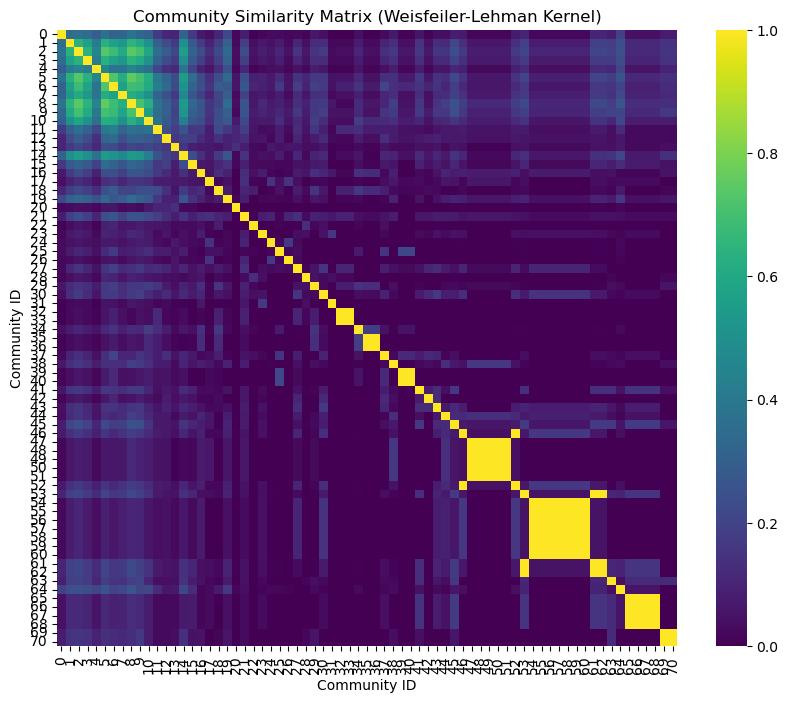

The most similar communities are 32 and 33 with a similarity score of 1.0000


In [28]:
start = time.time()
# Prepare the data
# We convert the dictionary values (the subgraphs) into a list
# We also keep the community IDs to label our matrix later
community_ids = list(community_subgraphs.keys())
nx_graphs = list(community_subgraphs.values())

# Convert NetworkX graphs to GraKeL graphs
for G_sub in nx_graphs:
    degrees = dict(G_sub.degree())
    nx.set_node_attributes(G_sub, degrees, 'label')

# Convert to GraKeL format
grakel_graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

# Initialize and fit the Weisfeiler-Lehman Kernel
wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)

end = time.time()
print(f"Time taken to convert graphs and compute kernel matrix: {end - start:.2f} seconds\n")

# Calculate the kernel matrix (similarity matrix)
kernel_matrix = wl_kernel.fit_transform(grakel_graphs)

# Visualize the Similarity Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(kernel_matrix, xticklabels=community_ids, yticklabels=community_ids, cmap="viridis")
plt.title("Community Similarity Matrix (Weisfeiler-Lehman Kernel)")
plt.xlabel("Community ID")
plt.ylabel("Community ID")
plt.show()

# Mask the diagonal (self-similarity is always 1)
np.fill_diagonal(kernel_matrix, 0)

# Find indices of the maximum value
max_idx = np.unravel_index(np.argmax(kernel_matrix, axis=None), kernel_matrix.shape)
com_a = community_ids[max_idx[0]]
com_b = community_ids[max_idx[1]]
score = kernel_matrix[max_idx]

print(f"The most similar communities are {com_a} and {com_b} with a similarity score of {score:.4f}")

## **3: Collapse graph**

We collapse that graph in such manner that each node is a community, preserving the attributes

In [10]:
start = time.time()

# Helper function to group nodes by community
def to_communities_dict(coms):
    inv_map = {}
    for k, v in coms.items():
        # Handle cases where v is a list (e.g., [0]) or a scalar
        val = v[0] if isinstance(v, list) else v
        inv_map.setdefault(val, []).append(k)
    return inv_map

# Function to calculate weight between two communities
def calculate_edge_weight(nodes_1, nodes_2):
    weight = 0
    for u in nodes_1:
        for v in nodes_2:
            if G.has_edge(u, v):
                # Convert the weight string to an integer
                w = G.edges[u, v].get("weight", 1)
                weight += int(w) 
    return weight

# Function to calculate internal weight (for self-loops)
def intra_community_weight(nodes):
    subgraph = G.subgraph(nodes)
    weight = 0
    for u, v, d in subgraph.edges(data=True):
        # Convert the weight string to an integer
        w = d.get("weight", 1)
        weight += int(w)
    return weight

# --- Main Collapse Process ---

# Prepare the partition dictionary
partition_dict = to_communities_dict(coms)

# Create the Quotient Graph
G_collapsed = nx.quotient_graph(
    G,
    list(partition_dict.values()), 
    edge_data=lambda x, y: {"weight": calculate_edge_weight(x, y)}
)

# Relabel nodes to be simple integers (Community IDs)}
mapping = {}
for node_set in G_collapsed.nodes():
    # Pick one node from the set to find which community ID it belongs to
    representative = list(node_set)[0]
    # Check if coms values are lists (like [0]) or scalars (like 0)
    comm_val = coms[representative]
    c_id = comm_val[0] if isinstance(comm_val, list) else comm_val
    mapping[node_set] = c_id

G_collapsed = nx.relabel_nodes(G_collapsed, mapping)

# Add self-loops to represent internal community connections (Tweets within the community)
for c_id, nodes in partition_dict.items():
    if c_id in G_collapsed:
        w = intra_community_weight(nodes)
        if w > 0:
            G_collapsed.add_edge(c_id, c_id, weight=w)

end = time.time()
print(f"Time taken to collapse the graph: {end - start:.2f} seconds\n")

# Verification
print(f"Original Graph: {G.number_of_nodes()} nodes")
print(f"Collapsed Graph: {G_collapsed.number_of_nodes()} nodes (communities)")
print(f"Collapsed Graph Edges: {G_collapsed.number_of_edges()}")

# Check the weights of the first few edges to make sure they are integers now
print("\nSample Edges in Collapsed Graph:")
for u, v, d in list(G_collapsed.edges(data=True))[:3]:
    print(f"Comm {u} -- Comm {v} : Weight {d['weight']}")

Time taken to collapse the graph: 159.63 seconds

Original Graph: 47544 nodes
Collapsed Graph: 71 nodes (communities)
Collapsed Graph Edges: 340

Sample Edges in Collapsed Graph:
Comm 0 -- Comm 1 : Weight 1325125
Comm 0 -- Comm 2 : Weight 397780
Comm 0 -- Comm 3 : Weight 959782


### Saving and loading G_colapsed and partition_dict to a local file
Now we will also save and load the `G_colapsed` and `partition_dict` to a local file and then load them from there. The reason is that collapsing the graph can sometime take a lot of time and in order to speed up the process when opening every time the notebook, we have saved and then upload the G_collapsed and partition_dict from locally saved variables. If the previous cell was run, then there is no need to run the next cell

In [5]:
# We need to also save the partition_dict to interpret the collapsed graph later!!!

"""
# Save the variable to a local file
my_variables = [G_collapsed, partition_dict]
for variable in my_variables:
    
    if variable is G_collapsed:
        with open('G_collapsed.pkl', 'wb') as file:
            pickle.dump(variable, file)
        print(f"Variable saved to G_collapsed.pkl")
    else:
        with open('partition_dict.pkl', 'wb') as file:
            pickle.dump(variable, file)
        print(f"Variable saved to partition_dict.pkl")
"""        
#-----------------------------------------------

# Loading the saved variable
paths = ['G_collapsed.pkl', 'partition_dict.pkl']
for file_path in paths:
    with open(file_path, 'rb') as file:
        if file_path == 'G_collapsed.pkl':
            G_collapsed = pickle.load(file)
        else:
            partition_dict = pickle.load(file)
    print(f"Variable loaded from {file_path}")

Variable loaded from G_collapsed.pkl
Variable loaded from partition_dict.pkl


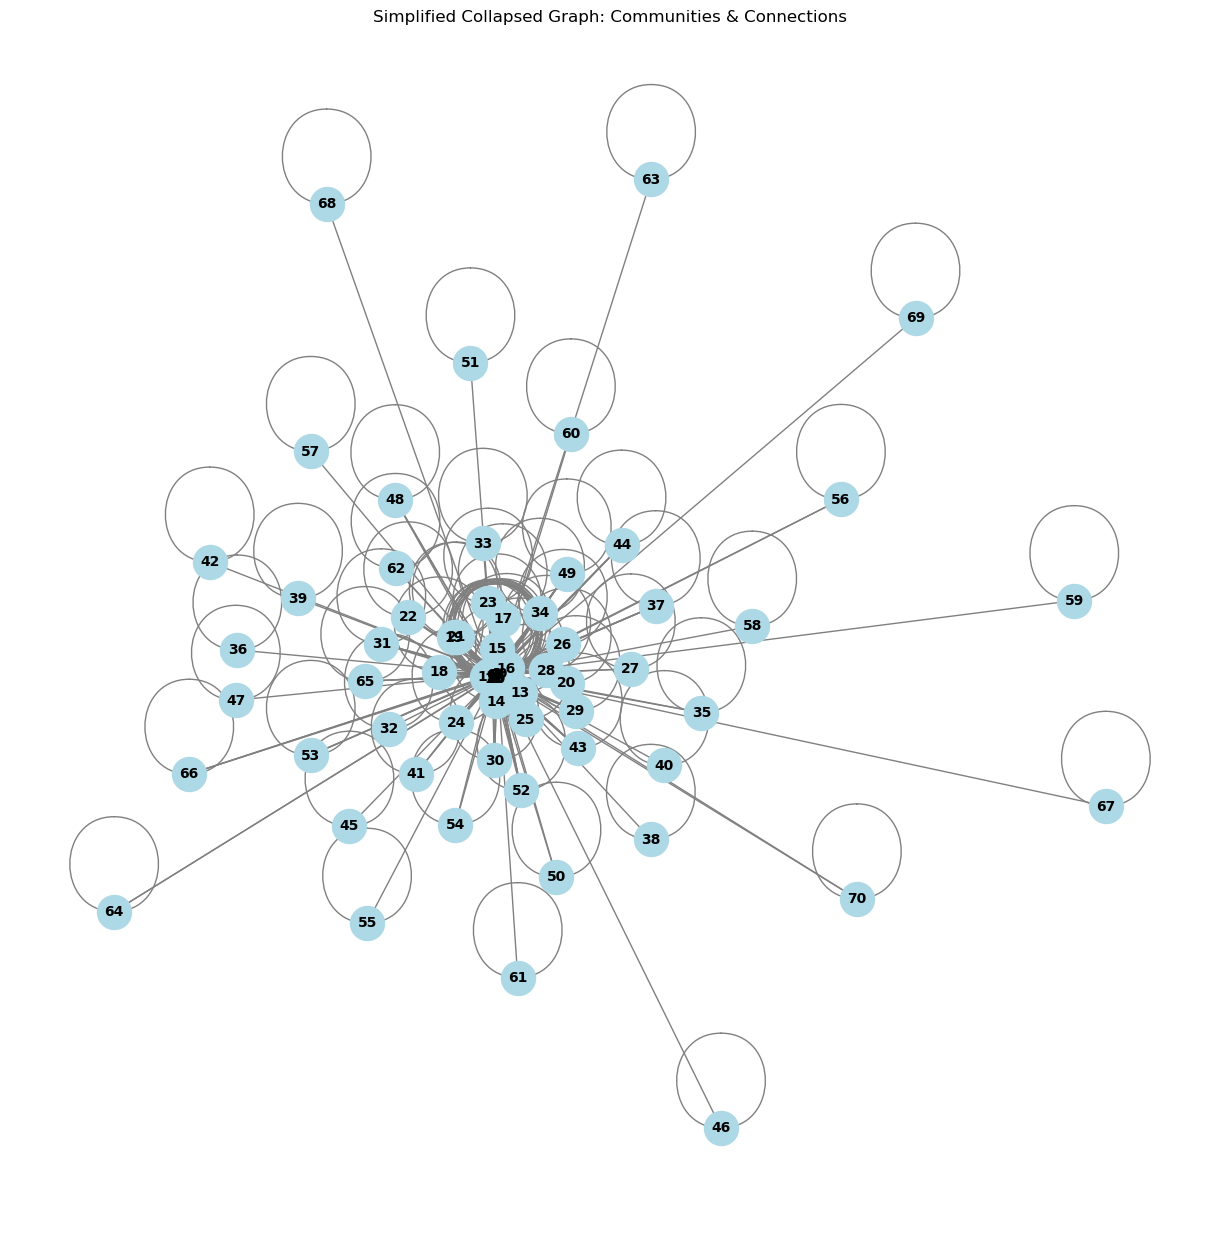

In [6]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G_collapsed, seed=42)

nx.draw(
    G_collapsed, 
    pos,
    with_labels=True,          # Show Community IDs
    node_color='lightblue',    # Simple color for all nodes
    node_size=600,             # Uniform size
    edge_color='gray',         # Uniform edge color
    font_size=10,
    font_weight='bold'
)

plt.title("Simplified Collapsed Graph: Communities & Connections")
plt.show()

## **4: Visualizations based on the different metrics.**

We apply different metrics that may be useful to get a better idea of ​​the communities, and create different visualizations based on the metrics.

### Step 1: Calculate Metrics & Create a Data Table
We will calculate the metrics and store them in a Pandas DataFrame. This makes it easy to spot the "VIP" communities immediately.

In [7]:
# 1. Calculate Centrality Metrics on the Collapsed Graph
# Degree: How many other communities is this one connected to?
degree_cent = nx.degree_centrality(G_collapsed)

# Betweenness: Does this community act as a bridge between unconnected topics?
# We use 'weight' because a stronger connection implies a "shorter" distance in information flow
betweenness_cent = nx.betweenness_centrality(G_collapsed, weight='weight')

# PageRank: Is this community connected to other "important" communities?
pagerank_cent = nx.pagerank(G_collapsed, weight='weight')

# 2. Compile Data into a DataFrame for Analysis
community_data = []

for node in G_collapsed.nodes():
    # Retrieve Size (number of original hashtags) from the partition dictionary
    # (Assuming 'partition_dict' from point 3 is still in memory)
    size = len(partition_dict[node])
    
    # Retrieve Internal Density (Self-loop weight)
    internal_w = G_collapsed.edges[node, node]['weight'] if G_collapsed.has_edge(node, node) else 0
    
    community_data.append({
        "Community_ID": node,
        "Size (#Hashtags)": size,
        "Internal_Tweets": internal_w,
        "Degree": degree_cent[node],
        "Betweenness": betweenness_cent[node],
        "PageRank": pagerank_cent[node]
    })

df_metrics = pd.DataFrame(community_data)

# 3. Print Global "Macro" Metrics
print(f"--- Macro Metrics of the Community Network ---")
print(f"Density: {nx.density(G_collapsed):.4f} (How saturated are the connections between topics?)")
print(f"Transitivity: {nx.transitivity(G_collapsed):.4f} (Do connected topics tend to form triangles?)")

# 4. Show top communities by PageRank (Importance)
print("\n--- Top 5 Communities by PageRank ---")
display(df_metrics.sort_values(by="PageRank", ascending=False).head(5))

--- Macro Metrics of the Community Network ---
Density: 0.1368 (How saturated are the connections between topics?)
Transitivity: 0.3249 (Do connected topics tend to form triangles?)

--- Top 5 Communities by PageRank ---


,Community_ID,Size (#Hashtags),Internal_Tweets,Degree,Betweenness,PageRank
1,1,7831,3525922,0.800000,0.354451,0.187064
3,3,6552,3092511,0.657143,0.249689,0.148838
0,0,11735,1725103,0.728571,0.234783,0.122414
2,2,6703,2175538,0.514286,0.296066,0.089928
4,4,5898,1173049,0.514286,0.327122,0.075573


### Step 2: Create Visualizations
Now we create two distinct visualizations to answer different questions about the structure.

### Visualization A: Influence & Volume (PageRank vs. Size)
Node Size: Represents the community's PageRank (Influence).

Node Color: Represents the Community Size (# of Hashtags).

Insight: Identifying small but highly influential communities (efficient topics) vs. large but isolated ones.

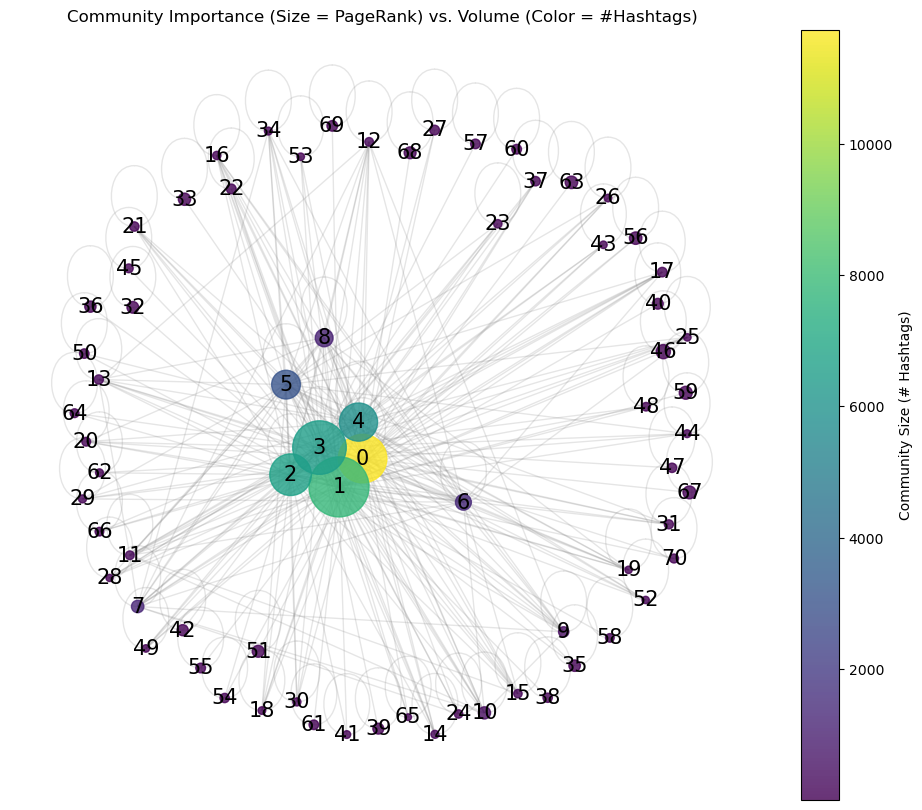

In [8]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_collapsed, k=3, seed=42)
pos = nx.spring_layout(G_collapsed, k=50, scale=6, seed=42)

# Normalize PageRank for sizing
pr_values = [pagerank_cent[n] for n in G_collapsed.nodes()]
node_sizes = [v * 10000 for v in pr_values]  # Scale up for visibility

# Color by Size (number of hashtags)
sizes_values = [len(partition_dict[n]) for n in G_collapsed.nodes()]

nodes = nx.draw_networkx_nodes(
    G_collapsed, pos,
    node_size=node_sizes,
    node_color=sizes_values,
    cmap=plt.cm.viridis,
    alpha=0.8
)

nx.draw_networkx_edges(G_collapsed, pos, alpha=0.2, edge_color='gray')
nx.draw_networkx_labels(G_collapsed, pos, font_size=15, font_color='black')

# Colorbar
cbar = plt.colorbar(nodes)
cbar.set_label('Community Size (# Hashtags)')

plt.title("Community Importance (Size = PageRank) vs. Volume (Color = #Hashtags)")
plt.axis('off')
plt.show()

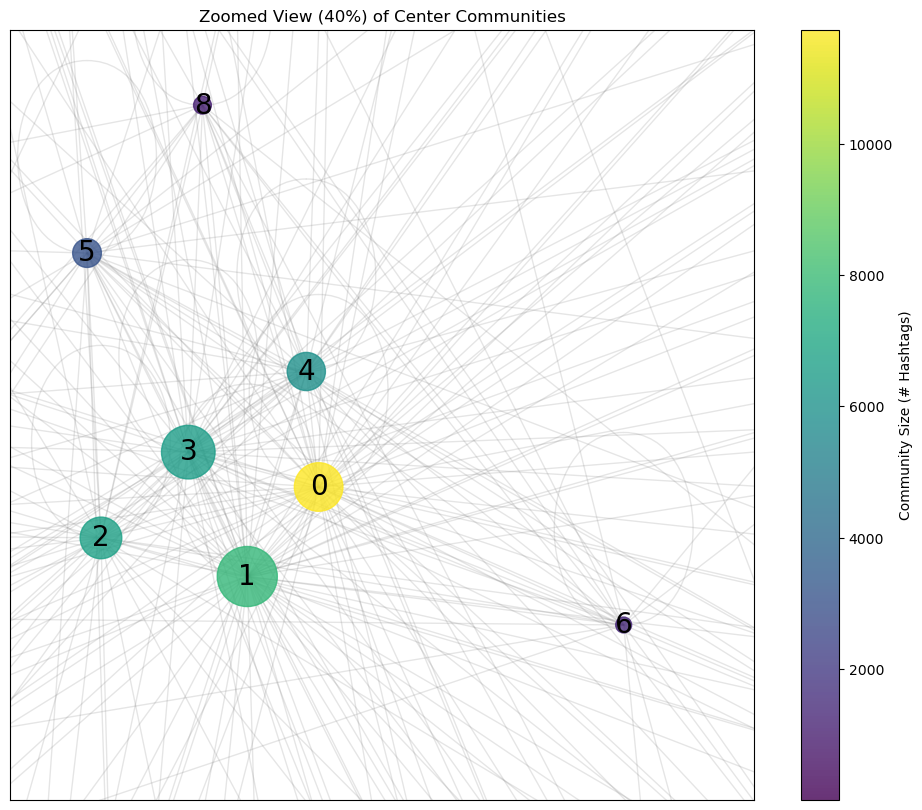

In [9]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_collapsed, k=50, scale=6, seed=42)

# --- METRICS CALCULATION (Same as before) ---
pr_values = [pagerank_cent[n] for n in G_collapsed.nodes()]
node_sizes = [v * 10000 for v in pr_values]
sizes_values = [len(partition_dict[n]) for n in G_collapsed.nodes()]

# --- DRAWING ---
nodes = nx.draw_networkx_nodes(
    G_collapsed, pos,
    node_size=node_sizes,
    node_color=sizes_values,
    cmap=plt.cm.viridis,
    alpha=0.8
)

nx.draw_networkx_edges(G_collapsed, pos, alpha=0.2, edge_color='gray')
nx.draw_networkx_labels(G_collapsed, pos, font_size=20, font_color='black')

# --- ZOOMING LOGIC ---
# Get the full range of node positions
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
y_max, y_min = max(y_values), min(y_values)

# Define a zoom factor (e.g., 0.2 means showing only the inner 20%)
zoom_factor = 0.40 

# Set the limits to the center fraction of the graph
plt.xlim(x_min * zoom_factor, x_max * zoom_factor)
plt.ylim(y_min * zoom_factor, y_max * zoom_factor)

# Add colorbar and show
cbar = plt.colorbar(nodes)
cbar.set_label('Community Size (# Hashtags)')
plt.title(f"Zoomed View ({int(zoom_factor*100)}%) of Center Communities")
plt.axis('on')
plt.show()

### Visualization B: The "Bridges" (Betweenness)
Node Size: Represents Betweenness Centrality.

Insight: Big nodes here are "gatekeepers." They connect disparate topics (e.g., a community connecting "Health" hashtags to "Economy" hashtags).

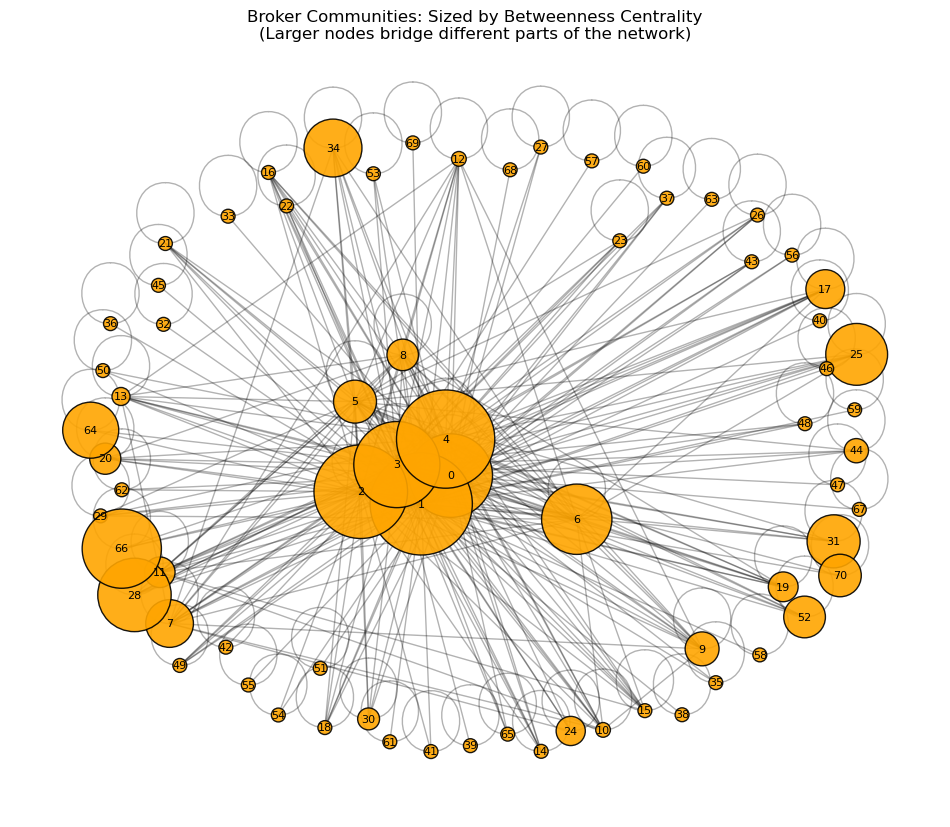

In [10]:
plt.figure(figsize=(12, 10))

# Normalize Betweenness for sizing
bw_values = [betweenness_cent[n] for n in G_collapsed.nodes()]
# Add a small base size so 0-betweenness nodes don't disappear
node_sizes_bw = [(v * 15000) + 100 for v in bw_values]

nodes = nx.draw_networkx_nodes(
    G_collapsed, pos,
    node_size=node_sizes_bw,
    node_color="orange",
    edgecolors="black",
    alpha=0.9
)

nx.draw_networkx_edges(G_collapsed, pos, alpha=0.3)
nx.draw_networkx_labels(G_collapsed, pos, font_size=8)

plt.title("Broker Communities: Sized by Betweenness Centrality\n(Larger nodes bridge different parts of the network)")
plt.axis('off')
plt.show()

## **5: Centrality and Macro-Analysis**

Now we analyze the structural importance of the communities within our collapsed network. Since we have simplified the graph so that each node represents an entire community of hashtags, we can now apply network metrics at a "macro" level to understand the overall discourse.

**Methodology:**
1.  **Centrality (Micro-level on Communities):** We will calculate `PageRank` (influence) and `Betweenness Centrality` (bridging potential) for each community node to identify the key players in the network.
2.  **Macro Metrics (Global Network Structure):** We will calculate `Density`, `Transitivity`, and `Assortativity` to describe the topology of the conversation—specifically, how interconnected and clustered the different topics are.

In [11]:
print("--- 1. IDENTIFYING CENTRAL NODES (Communities) ---")

# Calculate Centrality Metrics
degree = nx.degree_centrality(G_collapsed)
betweenness = nx.betweenness_centrality(G_collapsed, weight='weight')
pagerank = nx.pagerank(G_collapsed, weight='weight')

# Create a DataFrame to rank them
df_centrality = pd.DataFrame({
    'Degree': degree,
    'Betweenness': betweenness,
    'PageRank': pagerank
})

# Display the "VIP" Communities
print("\nTop 5 Communities by INFLUENCE (PageRank):")
display(df_centrality.sort_values(by='PageRank', ascending=False).head(5))

print("\nTop 5 Communities by BRIDGING (Betweenness):")
display(df_centrality.sort_values(by='Betweenness', ascending=False).head(5))


print("\n\n--- 2. MACRO METRICS (Network Structure) ---")

# Density
dens = nx.density(G_collapsed)
print(f"Density: {dens:.4f}")
# Interpretation:
print(f"-> {dens*100:.2f}% of all possible connections between communities exist.")

# Transitivity
trans = nx.transitivity(G_collapsed)
print(f"Transitivity: {trans:.4f}")
# Interpretation:
print(f"-> Probability that two topics connected to a middle topic are also connected to each other is {trans:.2f}.")

# Assortativity (by Degree)
# Do popular communities connect to other popular communities?
assort_deg = nx.degree_assortativity_coefficient(G_collapsed)
print(f"Degree Assortativity: {assort_deg:.4f}")

# Assortativity (by Size)
# We need to set the 'size' attribute first if it's not already there
for node in G_collapsed.nodes():
    G_collapsed.nodes[node]['size'] = len(partition_dict[node])

assort_size = nx.numeric_assortativity_coefficient(G_collapsed, 'size')
print(f"Size Assortativity: {assort_size:.4f}")

# Interpretation of Assortativity
if assort_size > 0:
    print("-> Positive Size Assortativity: Big communities talk to big communities, small to small.")
else:
    print("-> Negative Size Assortativity: Small communities tend to link to big communities (Hub-and-Spoke).")

--- 1. IDENTIFYING CENTRAL NODES (Communities) ---

Top 5 Communities by INFLUENCE (PageRank):


,Degree,Betweenness,PageRank
1,0.800000,0.354451,0.187064
3,0.657143,0.249689,0.148838
0,0.728571,0.234783,0.122414
2,0.514286,0.296066,0.089928
4,0.514286,0.327122,0.075573



Top 5 Communities by BRIDGING (Betweenness):


,Degree,Betweenness,PageRank
1,0.800000,0.354451,0.187064
4,0.514286,0.327122,0.075573
2,0.514286,0.296066,0.089928
3,0.657143,0.249689,0.148838
0,0.728571,0.234783,0.122414




--- 2. MACRO METRICS (Network Structure) ---
Density: 0.1368
-> 13.68% of all possible connections between communities exist.
Transitivity: 0.3249
-> Probability that two topics connected to a middle topic are also connected to each other is 0.32.
Degree Assortativity: -0.4925
Size Assortativity: -0.4272
-> Negative Size Assortativity: Small communities tend to link to big communities (Hub-and-Spoke).


### Conclusions on Network Structure

Based on the calculated metrics, we can draw the following conclusions about the structure of the hashtag network:

**1. Key Communities (Centrality):**
* **Influence (PageRank):** Community **#1** is the most influential node in the network, followed closely by **#3, #0, and #2**. These communities likely represent the dominant "mainstream" topics of the election (e.g., broad hashtags like `#elections2020` or major candidates) that most other topics reference.
* **Bridging (Betweenness):** Community **#1** also holds the highest Betweenness centrality, acting as the primary "bridge" or gatekeeper. This means it connects otherwise disparate clusters of conversation. Interestingly, Community **#0** appears in the top 5 for influence but has notably lower bridging power, suggesting it might be a popular destination that doesn't necessarily facilitate flow to other topics.

**2. Global Structure (Macro Metrics):**
* **Density (0.1368):** The network has a density of roughly **13.68%**. While this might seem low in absolute terms, for a graph of distinct communities, it indicates a meaningful level of interconnection. It suggests that while distinct topics exist, they are not isolated; there is a reasonable flow of information between about 1 in 7 pairs of communities.
* **Transitivity (0.3249):** The transitivity score is **0.32**, indicating a moderate tendency towards clustering. If Topic A is related to Topic B, and B to C, there is a **32%** probability that A is also related to C. This suggests the presence of thematic clusters, but the network is not a set of completely closed "echo chambers."
* **Assortativity (-0.4272):** We observe a **strongly negative size assortativity** (and degree assortativity of **-0.49**). This confirms a distinct **"Hub-and-Spoke" architecture**. Small, niche communities do not tend to connect with each other; instead, they connect primarily to the massive, central "hub" communities. The discourse is highly centralized around the main topics rather than distributed among peers.

## **6. Overlapping vs. non-verlapping communities**

For this project on the 2020 US Elections, we explicitly chose to use **Non-Overlapping Communities** (the Leiden Algorithm).

### Why we chose this approach:

Our primary goal was to construct a clear, unambiguous map of political polarization. By enforcing a strict partition where each hashtag belongs to exactly one group, we were able to successfully simplify the chaotic network into the Collapsed Graph created at Point 3. This distinct separation was essential for visualizing the "Hub-and-Spoke" architecture and defining the boundaries between opposing factions (e.g., the Pro-Trump camp vs. the Pro-Biden camp) without structural ambiguity.

### Why Overlapping Communities were not worth it:

Implementing Overlapping Communities (like Clique Percolation) would not have added significant value to this macro-analysis. The algorithm proved to be computationally prohibitive due to the network's high density, and the results would have merely blurred the political lines we aimed to define. For the purpose of identifying the dominant actors and the global structure of the debate, the crisp partition provided by Leiden was far more effective and efficient.

## **7. Largest VS smallest communities**

Largest Community #0: 11735 hashtags
Smallest Community #70: 3 hashtags
Plotting the 'Core' of Community #0 (30 nodes)...


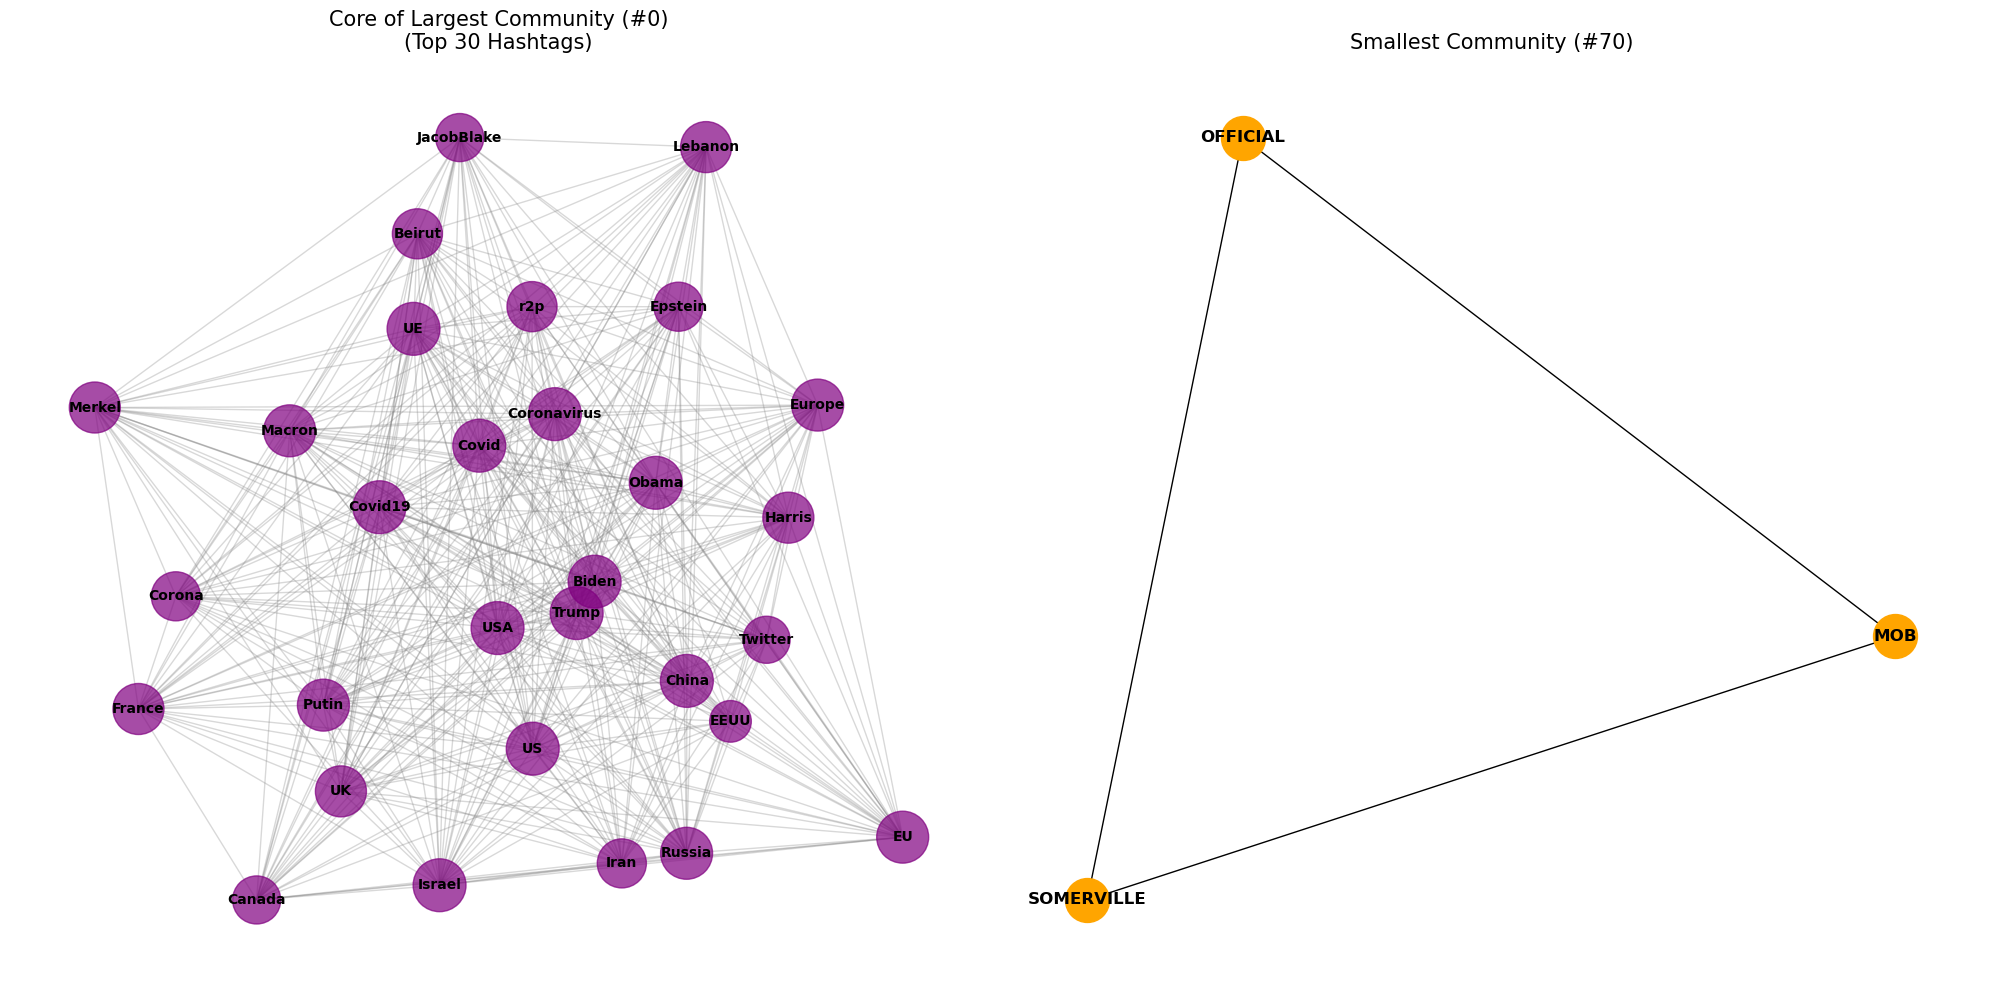

In [40]:
# Identify Largest and Smallest Communities (Same as before)
sorted_communities = sorted(partition_dict.items(), key=lambda x: len(x[1]), reverse=True)
largest_id, largest_nodes = sorted_communities[0]
smallest_id, smallest_nodes = sorted_communities[-1]

print(f"Largest Community #{largest_id}: {len(largest_nodes)} hashtags")
print(f"Smallest Community #{smallest_id}: {len(smallest_nodes)} hashtags")

# Extract Subgraphs
G_large_full = G.subgraph(largest_nodes)
G_small = G.subgraph(smallest_nodes)

# Instead of plotting 6,000+ nodes, we plot the "Core" (Top 50 nodes by degree)
# This represents the skeleton of the conversation without the noise.
top_k = 30
degree_dict = dict(G_large_full.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:top_k]
G_large_core = G_large_full.subgraph(top_nodes)

print(f"Plotting the 'Core' of Community #{largest_id} ({top_k} nodes)...")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Largest Community (CORE)
pos_large = nx.spring_layout(G_large_core, k=0.3, seed=42)

# Size by degree within the core
node_sizes = [G_large_core.degree(n) * 50 for n in G_large_core.nodes()]

nx.draw_networkx_edges(G_large_core, pos_large, ax=axes[0], alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(G_large_core, pos_large, ax=axes[0], node_size=node_sizes, node_color="purple", alpha=0.7)
nx.draw_networkx_labels(G_large_core, pos_large, ax=axes[0], font_size=10, font_weight="bold")

axes[0].set_title(f"Core of Largest Community (#{largest_id})\n(Top {top_k} Hashtags)", fontsize=15)
axes[0].axis('off')

# Plot Smallest Community (FULL)
# Small communities are usually tiny, so we can plot the whole thing
pos_small = nx.spring_layout(G_small, seed=42)
nx.draw(G_small, pos_small, ax=axes[1], with_labels=True, node_color="orange", node_size=1000, font_size=12, font_weight="bold")
axes[1].set_title(f"Smallest Community (#{smallest_id})", fontsize=15)

plt.tight_layout()
plt.show()

### Conclusion: The Topology of Political Discourse

This visualization illustrates the extreme structural contrast within the 2020 election conversation on Twitter, revealing how topics organize themselves by relevance:

* **The "Global Core" (Left):** The **Largest Community** is defined by **narrative convergence**. The high density of connections (edges) between domestic figures (`#Trump`, `#Biden`), global crises (`#Covid19`), and international relations (`#Iran`, `#Russia`) indicates that these were not discussed as separate issues. Instead, the "mainstream" consensus treated the election, the pandemic, and geopolitics as a single, entangled super-topic.

* **The "Micro-Bubble" (Right):** The **Smallest Community** represents **structural isolation**. The closed triangular loop (`#Somerville`, `#Mob`, `#Official`) suggests a specific, localized event that operated completely independently of the national narrative. This proves that while the network is dominated by a loud central core, highly specific local discussions can still exist in "air-gapped" pockets on the periphery.

## **8: Community Characterization**

To determine if the detected communities represent coherent topics of discussion by analyzing their most central hashtags.

In [41]:
# Convert weights to integers in the original graph G
# This ensures that degree calculations can perform addition correctly.
for u, v, data in G.edges(data=True):
    if 'weight' in data:
        # Convert string '5' to integer 5
        data['weight'] = int(data['weight'])


# Number of top hashtags to display per community
top_n = 10

print("\n--- Content Characterization of Communities ---")

# Iterate through communities (sorted by size for relevance)
# Assuming 'partition_dict' is available from point 3: {community_id: [node_list]}
sorted_communities = sorted(partition_dict.items(), key=lambda x: len(x[1]), reverse=True)

for c_id, nodes in sorted_communities[:10]: # Analyze top 10 largest communities
    # Create subgraph for this community
    G_comm = G.subgraph(nodes)
    
    # Strategy 1: Most Connected (Hubs) within the community
    degree_dict = dict(G_comm.degree(weight='weight'))
    
    # Sort by degree (highest first)
    top_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    print(f"\nCommunity #{c_id} ({len(nodes)} hashtags):")
    # Using 'deg' for the degree value in the print statement
    print(f"  Top Hubs (Degree): {', '.join([f'{tag} ({deg})' for tag, deg in top_degree])}")


--- Content Characterization of Communities ---

Community #0 (11735 hashtags):
  Top Hubs (Degree): Trump (618798), Biden (356351), USA (130105), China (38244), Coronavirus (37364), Obama (33006), Cuba (29789), r2p (29298), Israel (29152), UK (28784)

Community #1 (7831 hashtags):
  Top Hubs (Degree): MAGA (818125), Trump2020 (530713), MAGA2020 (305600), KAG (216369), DonaldTrump (88287), KAG2020 (86878), AmericaFirst (85444), JoeBiden (69814), StopTheSteal (69578), America (58863)

Community #2 (6703 hashtags):
  Top Hubs (Degree): trump (298606), maga (173824), biden (126397), vote (93489), trump2020 (87481), election2020 (86448), usa (69276), politics (65910), election (64829), covid (51879)

Community #3 (6552 hashtags):
  Top Hubs (Degree): BidenHarris2020 (599489), VoteBlue (288695), Biden2020 (188131), VOTE (133253), BidenHarris (112084), Vote (100231), VoteHimOut (84317), VoteBlueToSaveAmerica (83838), VoteEarly (82538), VoteBidenHarris2020 (71111)

Community #4 (5898 hashtag

**Analysis of Major Communities:**

* **Community #0 (The "Mainstream/International" Cluster):**
  * **Top Hashtags:** `Trump`, `Biden`, `USA`, `China`, `Coronavirus`, `Obama`, `Cuba`.
  * **Characterization:** This is the largest community (11,735 hashtags). It appears to be a broad, international, and general discussion forum. It connects the main candidates (`Trump`, `Biden`) with major geopolitical entities (`China`, `Cuba`, `Israel`, `UK`) and global events like `Coronavirus`. It represents the general news cycle.

* **Community #1 (The "Pro-Trump / MAGA" Cluster):**
  * **Top Hashtags:** `MAGA`, `Trump2020`, `MAGA2020`, `KAG`, `DonaldTrump`, `StopTheSteal`.
  * **Characterization:** This community is defined by strong support for Donald Trump. The high degree of slogans like `MAGA`, `KAG` (Keep America Great), and `AmericaFirst`, along with post-election narratives like `StopTheSteal`, clearly marks this as a distinct partisan cluster.

* **Community #2 (The "General Election/Process" Cluster):**
  * **Top Hashtags:** `vote`, `election2020`, `politics`, `election`, `usa`, `covid`.
  * **Characterization:** While it shares terms with others, the high prominence of generic terms like `vote`, `politics`, and `election` suggests this community focuses more on the **process** of the election and general political discussion rather than specific candidate advocacy.

* **Community #3 (The "Pro-Biden / Vote Blue" Cluster):**
  * **Top Hashtags:** `BidenHarris2020`, `VoteBlue`, `Biden2020`, `VoteHimOut`, `VoteBlueToSaveAmerica`.
  * **Characterization:** This is the Democratic counterpart to Community #1. The language focuses on the ticket (`BidenHarris`) and action-oriented slogans (`VoteBlue`, `VoteHimOut`), indicating a mobilized base of support for the Democratic party.

* **Community #4 (The "Election Night / Real-time" Cluster):**
  * **Top Hashtags:** `Election2020`, `ElectionDay`, `ElectionNight`, `ElectionResults2020`, `MSNBC2020`, `AFazenda12` (likely noise/spam crossover).
  * **Characterization:** This community seems focused on the **event** itself rather than a specific candidate. Tags like `ElectionNight` and `ElectionResults2020` suggest real-time tracking of the polls. The presence of `MSNBC2020` indicates media consumption. Interestingly, `AFazenda12` (a Brazilian reality show) appears here, suggesting that high-volume spam or bot networks might have hijacked trending election tags to promote unrelated content, creating a "spam bridge" into this community.

* **Community #5 (The "Consumer/Gamer" Niche):**
  * **Top Hashtags:** `XboxSeriesX`, `nintendoswitch`, `ps5restock`, `blackfriday`, `GiftAGamer`.
  * **Characterization:** This is a distinct non-political cluster. It revolves around gaming consoles (`Xbox`, `PS5`) and shopping events (`BlackFriday`). Its presence likely stems from the timing of the election (Nov 2020) coinciding with major console launches, or bots using trending election tags to spam consumer content.

* **Community #6 (The "Tech/Coding" Niche):**
  * **Top Hashtags:** `AI`, `DataScience`, `coding`, `VR`, `robotics`, `IoT`.
  * **Characterization:** Similar to #5, this is a distinct thematic cluster focused on technology. It might be linked to the main graph through discussions on election technology or data analysis, but it forms a specific vocabulary separate from the candidates.

* **Community #7 (The "Voter Fraud / Stop the Steal" Cluster):**
  * **Top Hashtags:** `TRUMP`, `BIDEN`, `ELECTION2020`, `FRAUD`, `VOTER`, `BALLOT`, `FIGHTBACK`, `TRIBUNALS`.
  * **Characterization:** This community is highly specific and intense. While it shares some generic tags (`TRUMP`, `BIDEN`), the presence of `FRAUD`, `FIGHTBACK`, and `TRIBUNALS` strongly suggests this group is focused on **contesting the election results**. It represents the "Stop the Steal" narrative, focusing on legal challenges (`TRIBUNALS`) and allegations of ballot issues.

* **Community #8 (The "Geographic / Swing State" Cluster):**
  * **Top Hashtags:** `GA`, `AZ`, `Texas`, `NC`, `Ohio`, `PA`, `CO`, `NorthCarolina`, `IA`.
  * **Characterization:** This is a geographically oriented community. The hashtags are almost exclusively state abbreviations (`GA` for Georgia, `AZ` for Arizona, `PA` for Pennsylvania). These were key swing states in the 2020 election. This cluster likely represents discussions about **specific state results, counting updates, or local campaigning**.
  
* **Community #9 (The "Japanese/Conspiracy" Niche):**
  * **Top Hashtags:** `不正選挙` (Rigged Election), `アメリカ大統領選挙` (US Presidential Election), `トランプ` (Trump).
  * **Characterization:** This community is linguistically distinct (Japanese) and thematically focused on the US election, echoing specific narratives like `ElectoralFraud`. It demonstrates the global reach of the event and how language groups form tight, separate clusters.

**Conclusion:**
Yes, it is entirely possible to characterize the communities intuitively. The Leiden algorithm successfully separated the network into **distinct partisan camps** (Comm #1 vs #3), **general discourse** (Comm #0, #2), and **unrelated thematic islands** like Gaming (#5) and Tech (#6).

## **9. Link predictions**

To predict which currently unconnected communities are most likely to interact in the future using standard link prediction algorithms.

In [42]:
print("--- Link Prediction on Communities (Collapsed Graph) ---")

# Identify Non-Existent Edges
# We want to predict connections between communities that are NOT currently linked
non_edges = list(nx.non_edges(G_collapsed))

print(f"Total possible new connections to predict: {len(non_edges)}")

# Calculate Prediction Scores
# Jaccard Coefficient
preds_jaccard = list(nx.jaccard_coefficient(G_collapsed, non_edges))

# Adamic-Adar Index
preds_adamic = list(nx.adamic_adar_index(G_collapsed, non_edges))

# Preferential Attachment
preds_pa = list(nx.preferential_attachment(G_collapsed, non_edges))

# Organize Results
# Sort by score to find the most likely links
top_jaccard = sorted(preds_jaccard, key=lambda x: x[2], reverse=True)[:5]
top_adamic = sorted(preds_adamic, key=lambda x: x[2], reverse=True)[:5]
top_pa = sorted(preds_pa, key=lambda x: x[2], reverse=True)[:5]

# Display Results
print("\n--- Top 5 Predicted Links (Jaccard) ---")
print("(Based on shared neighbors)")
for u, v, p in top_jaccard:
    print(f"Comm #{u} -- Comm #{v} (Score: {p:.4f})")

print("\n--- Top 5 Predicted Links (Adamic-Adar) ---")
print("(Based on unique shared neighbors)")
for u, v, p in top_adamic:
    print(f"Comm #{u} -- Comm #{v} (Score: {p:.4f})")

print("\n--- Top 5 Predicted Links (Preferential Attachment) ---")
print("(Based on 'Rich get Richer' - High Degree nodes linking)")
for u, v, p in top_pa:
    print(f"Comm #{u} -- Comm #{v} (Score: {p:.4f})")

--- Link Prediction on Communities (Collapsed Graph) ---
Total possible new connections to predict: 2216

--- Top 5 Predicted Links (Jaccard) ---
(Based on shared neighbors)
Comm #13 -- Comm #15 (Score: 0.7500)
Comm #14 -- Comm #18 (Score: 0.7500)
Comm #14 -- Comm #21 (Score: 0.7500)
Comm #14 -- Comm #28 (Score: 0.7500)
Comm #18 -- Comm #21 (Score: 0.7500)

--- Top 5 Predicted Links (Adamic-Adar) ---
(Based on unique shared neighbors)
Comm #7 -- Comm #13 (Score: 3.0329)
Comm #11 -- Comm #12 (Score: 3.0291)
Comm #9 -- Comm #11 (Score: 3.0166)
Comm #10 -- Comm #12 (Score: 3.0056)
Comm #9 -- Comm #13 (Score: 2.6636)

--- Top 5 Predicted Links (Preferential Attachment) ---
(Based on 'Rich get Richer' - High Degree nodes linking)
Comm #1 -- Comm #29 (Score: 392.0000)
Comm #1 -- Comm #23 (Score: 336.0000)
Comm #3 -- Comm #29 (Score: 322.0000)
Comm #0 -- Comm #23 (Score: 306.0000)
Comm #1 -- Comm #66 (Score: 280.0000)


**Results & Interpretation:**

* **Jaccard & Adamic-Adar Predictions:**
    * These algorithms prioritize communities that share many common neighbors (structural overlap).
    * **Top Predictions:** A strong cluster of predictions involves communities **#13, #14, #18, and #21** (e.g., *Comm #13 -- Comm #15* and *Comm #14 -- Comm #18*).
    * **Interpretation:** These communities likely represent a specific thematic sub-group (e.g., different aspects of a single candidate's policy or regional discussions). They are already "surrounding" each other in the network, so a direct link forming between them is semantically probable to "close the loop."

* **Preferential Attachment Predictions:**
    * This metric predicts links based purely on degree (popularity). It assumes "the rich get richer."
    * **Top Predictions:** The scores here are massive (300+) compared to Jaccard/Adamic (0.75-3.0), driven by the huge degree of the central hubs.
    * **Key Hubs:** Community **#1** appears in 3 out of the top 5 predictions (*Comm #1 -- Comm #29*, *Comm #1 -- Comm #23*, etc.).
    * **Interpretation:** This confirms that **Community #1 is the dominant hub** of the network. The algorithm predicts that smaller or medium-sized communities (like #29, #23, #66) are destined to connect to this main hub simply because of its gravitational pull on the conversation.

**Conclusion:**
* **Short-Term Evolution (Jaccard/Adamic):** We expect tighter clustering within the sub-groups (Communities 13, 14, 18, 21), leading to more dense "echo chambers."
* **Long-Term Evolution (Preferential Attachment):** The network will likely become even more centralized around **Community #1**, reinforcing the "Hub-and-Spoke" structure identified in Exercise 5.